In [2]:
from datasets import load_dataset

ds = load_dataset("PatronusAI/financebench")

In [3]:
len(ds["train"])

150

In [4]:
for key in ds["train"][0].keys():
    print(key)

financebench_id
company
doc_name
question_type
question_reasoning
domain_question_num
question
answer
justification
dataset_subset_label
evidence
gics_sector
doc_type
doc_period
doc_link


In [5]:
ds["train"][0]["doc_link"]

'https://investors.3m.com/financials/sec-filings/content/0001558370-19-000470/0001558370-19-000470.pdf'

In [6]:
ds["train"][0]["doc_name"]

'3M_2018_10K'

In [26]:
print(ds["train"][0]["evidence"][0]["doc_name"])
print(ds["train"][0]["evidence"][0]["evidence_page_num"])

3M_2018_10K
59


In [10]:
for i in range (10):
    print(ds["train"][i]["evidence"][0]["evidence_page_num"])

59
57
47
26
24
4
0
61
68
69


In [33]:
import fitz
from pathlib import Path
import time
from concurrent.futures import ThreadPoolExecutor, as_completed
import io
from base64 import b64encode
import csv

DPI = 300
FORMAT = "png"

def process_single_pdf(args):
    """Process a single PDF file and return base64 encoded images, or a dict with error info if failure occurs"""
    pdf_file, dpi, fmt = args
    
    zoom = dpi / 72.0
    mat = fitz.Matrix(zoom, zoom)
    
    start = time.time()
    try:
        doc = fitz.open(pdf_file)
    except Exception as e:
        return {"error": str(e), "filename": pdf_file.name}
    
    filename = pdf_file.stem
    pages_data = []
    
    for i, page in enumerate(doc, start=1):
        pix = page.get_pixmap(matrix=mat, alpha=False)
        buf = io.BytesIO()
        img_bytes = pix.pil_tobytes(format=fmt.upper())
        buf.write(img_bytes)
        byte_data = buf.getvalue()
        base64_str = b64encode(byte_data).decode("utf-8")
        
        pages_data.append({
            "source_pdf": pdf_file.name,
            "page_number": i,
            "base64": base64_str
        })
    
    doc.close()
    elapsed = time.time() - start
    print(f"Processed {len(pages_data)} pages from {pdf_file.name} in {elapsed:.2f} seconds.")
    
    # Return as dict for downstream processing, so the logic in process_pdfs_to_base64 works
    return {
        "filename": pdf_file.name,
        "pdf_stem": filename,
        "pages": pages_data,
        "num_pages": len(pages_data),
        "time": elapsed
    }

def process_pdfs_to_base64(
    pdf_folder="financebench-pdfs",
    dpi=DPI,
    fmt=FORMAT,
    max_workers=4,
    number_pdfs=None
):
    pdf_path = Path(pdf_folder)
    pdf_files = list(pdf_path.glob("*.pdf"))
    
    if not pdf_files:
        print("No PDF files found.")
        return []
    
    total_pdfs = len(pdf_files)
    if number_pdfs is not None:
        print(f"Processing up to {number_pdfs} PDFs using {max_workers} workers...")
    else:
        print(f"Processing {total_pdfs} PDFs using {max_workers} workers...")
    
    failed_to_open = []
    all_results = []

    def is_failure(result):
        # If a failure, result will have "error" key and not "pages"
        return isinstance(result, dict) and "error" in result and "pages" not in result

    if number_pdfs is not None:
        processed_count = 0
        pdf_iter = iter(pdf_files)
        with ThreadPoolExecutor(max_workers=max_workers) as executor:
            futures_map = {}
            while processed_count < number_pdfs:
                try:
                    next_pdf = next(pdf_iter)
                except StopIteration:
                    break
                future = executor.submit(process_single_pdf, (next_pdf, dpi, fmt))
                futures_map[future] = next_pdf

                finished_futures = []
                for f in as_completed([future]):
                    result = f.result()
                    finished_futures.append(f)
                    if not is_failure(result):
                        print(f"Processed {result.get('num_pages', '?')} pages from {result.get('filename', '?')} in {result.get('time', 0):.2f} seconds.")
                        all_results.append(result)
                        processed_count += 1
                    else:
                        print(f"Could not open {result.get('filename', '?')}: {result.get('error', '')}")
                        failed_to_open.append(result.get('filename', '?'))
                for f in finished_futures:
                    futures_map.pop(f, None)

            for f in as_completed(list(futures_map)):
                result = f.result()
                if not is_failure(result):
                    if processed_count < number_pdfs:
                        print(f"Processed {result.get('num_pages', '?')} pages from {result.get('filename', '?')} in {result.get('time', 0):.2f} seconds.")
                        all_results.append(result)
                        processed_count += 1
                else:
                    print(f"Could not open {result.get('filename', '?')}: {result.get('error', '')}")
                    failed_to_open.append(result.get('filename', '?'))
        if processed_count < number_pdfs:
            print(f"\nWarning: Only {processed_count} PDFs could be successfully processed (requested {number_pdfs}).")
    else:
        with ThreadPoolExecutor(max_workers=max_workers) as executor:
            futures_map = {executor.submit(process_single_pdf, (pdf_file, dpi, fmt)): pdf_file for pdf_file in pdf_files}
            for future in as_completed(futures_map):
                result = future.result()
                if not is_failure(result):
                    print(f"Processed {result.get('num_pages', '?')} pages from {result.get('filename', '?')} in {result.get('time', 0):.2f} seconds.")
                    all_results.append(result)
                else:
                    print(f"Could not open {result.get('filename', '?')}: {result.get('error', '')}")
                    failed_to_open.append(result.get('filename', '?'))
    
    if failed_to_open:
        print("\nFailed to open the following PDF files:")
        for fname in failed_to_open:
            print(fname)
    
    print(f"\nSuccessfully processed {len(all_results)} PDF(s).")
    return all_results

def save_results_to_csv(results, output_file="pdf_base64_encodings.csv"):
    """Save the base64 encodings to a CSV file"""
    with open(output_file, 'w', newline='', encoding='utf-8') as csvfile:
        fieldnames = ['pdf_filename', 'pdf_stem', 'page_number', 'base64_encoding']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
        for pdf_result in results:
            for page in pdf_result['pages']:
                writer.writerow({
                    'pdf_filename': pdf_result['filename'],
                    'pdf_stem': pdf_result['pdf_stem'],
                    'page_number': page['page_number'],
                    'base64_encoding': page['base64']
                })
    print(f"\nSaved base64 encodings to {output_file}")

In [35]:

pdf_processing_start = time.time()
results = process_pdfs_to_base64(number_pdfs=1, max_workers=1)
print(f"PDF processing completed in {time.time() - pdf_processing_start:.2f} seconds.")

# Save to CSV
if results:
    save_results_to_csv(results)

Processing up to 1 PDFs using 1 workers...
Could not open KRAFTHEINZ_2019_10K.pdf: cannot open broken document
Processed 179 pages from JPMORGAN_2021Q1_10Q.pdf in 22.68 seconds.
Processed 179 pages from JPMORGAN_2021Q1_10Q.pdf in 22.68 seconds.

Failed to open the following PDF files:
KRAFTHEINZ_2019_10K.pdf

Successfully processed 1 PDF(s).
PDF processing completed in 22.68 seconds.

Saved base64 encodings to pdf_base64_encodings.csv


In [3]:
import pandas as pd

df = pd.read_csv("pdf_base64_encodings.csv")

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 179 entries, 0 to 178
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   pdf_filename     179 non-null    object
 1   pdf_stem         179 non-null    object
 2   page_number      179 non-null    int64 
 3   base64_encoding  179 non-null    object
dtypes: int64(1), object(3)
memory usage: 5.7+ KB


In [50]:
def filter_by_docname(docname):
    result = None
    for entry in ds["train"]:
        for ev in entry.get("evidence", []):
            if ev.get("doc_name") == docname:
                result = entry
                break
    return result

result = filter_by_docname("JPMORGAN_2021Q1_10Q")
print(result["doc_name"])

JPMORGAN_2021Q1_10Q


In [59]:
print(result["question"])
print(result["answer"])
print(result["evidence"][0]["evidence_page_num"])


If JPM went bankrupted by the end by 2021 Q1 and liquidated all of its assets to pay its shareholders, how much could each shareholder get?
They could receive $66.56 per share.
5


In [56]:
print(df.iloc[4]["pdf_filename"])
print(df.iloc[4]["page_number"])

JPMORGAN_2021Q1_10Q.pdf
5


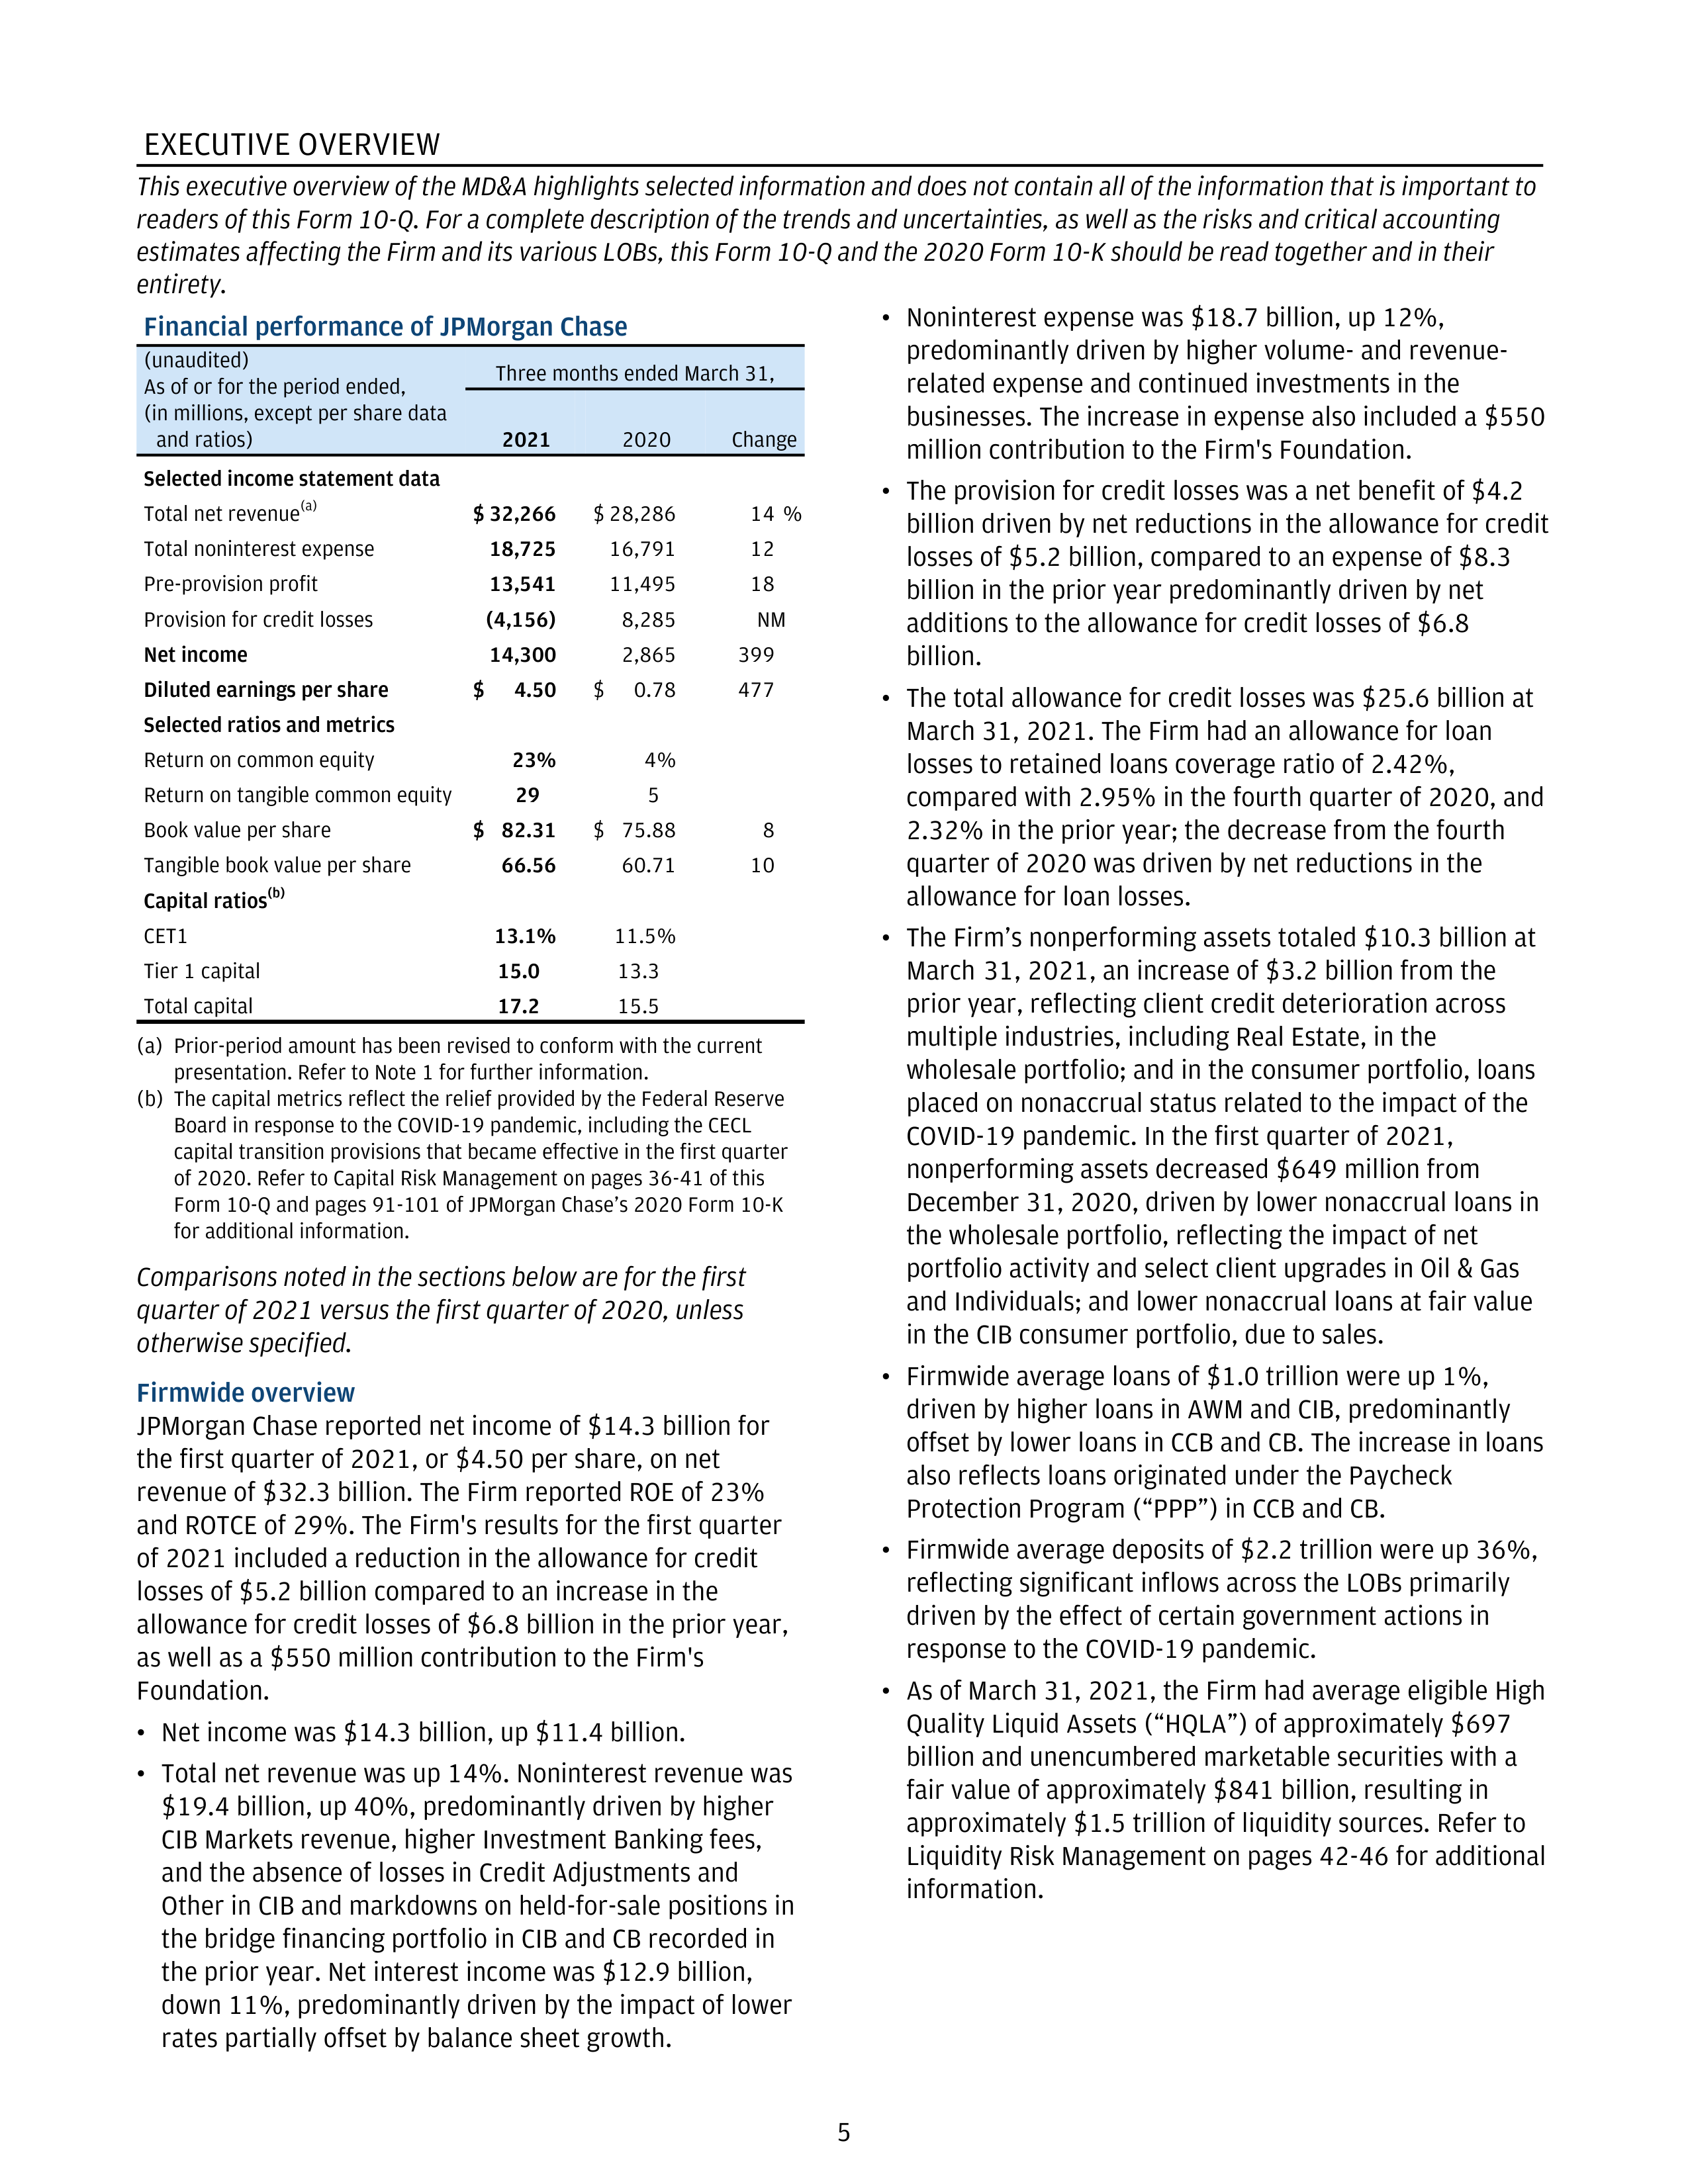

In [57]:
from IPython.display import display, Image
from base64 import b64decode
display(Image(data=b64decode(df.iloc[4]["base64_encoding"])))

In [ ]:
!pip install git+https://github.com/weaviate/weaviate-python-client@multi2multivec-weaviate

In [ ]:
import weaviate
from weaviate.config import AdditionalConfig, Timeout

# client = weaviate.connect_to_weaviate_cloud(...)

In [15]:
client.collections.delete("FinanceBench")

In [ ]:
from weaviate.collections.classes.config import Configure, DataType, Property
from pydantic import AnyHttpUrl

finance_bench_collection = client.collections.create(
    name="FinanceBench",
    properties=[
        Property(name="page_number", data_type=DataType.INT),
        Property(name="page_image", data_type=DataType.BLOB),
    ],
    vector_config=Configure.MultiVectors.multi2vec_weaviate(
        base_url=AnyHttpUrl("https://dev-embedding.labs.weaviate.io"),
        image_fields=["page_image"],
        model="ModernVBERT/colmodernvbert",
    ),
)

In [17]:
total = 0
with finance_bench_collection.batch.fixed_size(20) as batch:
    for idx, row in df.iterrows():
        batch.add_object(
            properties={
                "page_number": row["page_number"]+1,
                "page_image": row["base64_encoding"],
            },
        )
        total += 1

print(f"Added {total} pages")

Added 179 pages


In [20]:
len(df.iloc[0]["base64_encoding"].encode('utf-8')) / 1024

697.73046875

In [18]:
query = "If JPM went bankrupted by the end by 2021 Q1 and liquidated all of its assets to pay its shareholders, how much could each shareholder get?"

objects = finance_bench_collection.query.near_text(
    query,
    return_metadata=["distance"],
    return_properties=["page_number"],
    limit=10,
).objects

for i, o in enumerate(objects):
    page_number = o.properties["page_number"]
    print(f"Rank {i+1}: {page_number}")
    print("---")


Rank 1: 160.0
---
Rank 2: 157.0
---
Rank 3: 159.0
---
Rank 4: 77.0
---
Rank 5: 8.0
---
Rank 6: 5.0
---
Rank 7: 156.0
---
Rank 8: 85.0
---
Rank 9: 47.0
---
Rank 10: 174.0
---
